<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/main/MLTSA_Lag_Llama_Fine_Tuning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lag-Llama Fine Tuning MLTSA

## Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.

In [1]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 505 (delta 154), reused 109 (delta 109), pack-reused 312 (from 3)
Receiving objects: 100% (505/505), 283.34 KiB | 1.24 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [2]:
cd /content/lag-llama

/content/lag-llama


In [3]:
!pip uninstall jax jaxlib tensorboard -y

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


In [4]:
!pip install -U -r requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [5]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 67.0MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


## Imports

We import the required packages and the lag llama estimator object which we can use to make predictions.

In [6]:
from itertools import islice

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm
import glob
import numpy as np

from scipy.signal import butter, lfilter

import torch

from lag_llama.gluon.estimator import LagLlamaEstimator

import sys
from types import ModuleType

from gluonts.evaluation import make_evaluation_predictions, MultivariateEvaluator
from gluonts.evaluation import Evaluator


<ipython-input-6-b6a62eef4d70>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [8]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32,
              num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False) # modified
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

# Zero Shot

## data : `M4-Weekly`

In [9]:
from gluonts.dataset.repository import get_dataset
dataset = get_dataset("m4_weekly")
train_dataset = dataset.train
test_dataset = dataset.test

In [10]:
print(f"dataset length: {len(test_dataset)}")

dataset length: 359


In [11]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length * 3
num_samples = 20
device = "cuda"
print(f"prediction_length {prediction_length}")

prediction_length 13


## NEW DATASET

In [30]:
!git clone https://github.com/nlandolfi/acc2022treelinearcascades_stocks.git

fatal: destination path 'acc2022treelinearcascades_stocks' already exists and is not an empty directory.


In [31]:
files = glob.glob("acc2022treelinearcascades_stocks/data/*")
files

['acc2022treelinearcascades_stocks/data/wba.csv',
 'acc2022treelinearcascades_stocks/data/v.csv',
 'acc2022treelinearcascades_stocks/data/hon.csv',
 'acc2022treelinearcascades_stocks/data/unh.csv',
 'acc2022treelinearcascades_stocks/data/mrk.csv',
 'acc2022treelinearcascades_stocks/data/amgn.csv',
 'acc2022treelinearcascades_stocks/data/cvx.csv',
 'acc2022treelinearcascades_stocks/data/msft.csv',
 'acc2022treelinearcascades_stocks/data/crm.csv',
 'acc2022treelinearcascades_stocks/data/ibm.csv',
 'acc2022treelinearcascades_stocks/data/intc.csv',
 'acc2022treelinearcascades_stocks/data/aapl.csv',
 'acc2022treelinearcascades_stocks/data/mmm.csv',
 'acc2022treelinearcascades_stocks/data/hd.csv',
 'acc2022treelinearcascades_stocks/data/mcd.csv',
 'acc2022treelinearcascades_stocks/data/cat.csv',
 'acc2022treelinearcascades_stocks/data/jpm.csv',
 'acc2022treelinearcascades_stocks/data/trv.csv',
 'acc2022treelinearcascades_stocks/data/gs.csv',
 'acc2022treelinearcascades_stocks/data/jnj.csv',


In [32]:
pd.read_csv(files[0], index_col=0)

,Open,High,Low,Close,Volume
Date,,,,,
05/12/21,54.14,54.3300,52.940,53.04,5481645
05/11/21,55.25,55.4500,53.912,54.24,5204153
05/10/21,55.24,55.9300,55.060,55.11,6248220
05/07/21,54.50,55.1948,54.390,54.53,4119741
05/06/21,54.47,54.5557,53.370,54.46,3966202
...,...,...,...,...,...
05/19/11,44.31,44.3510,43.950,44.23,3731820
05/18/11,44.30,44.3400,43.810,44.19,5440096
05/17/11,44.84,44.9900,44.080,44.30,6256302


In [101]:
data = np.zeros((len(files)-1,  pd.read_csv(files[0], index_col=0).shape[0])) #prep data array for all files

In [102]:
#remove
j = 0
for i,f in enumerate(files):
  _ = pd.read_csv(f, index_col=0)
  if len(_) < data.shape[1]:
    continue

  data[j, :len(_[' Volume'])] = _[' Volume'].values
  j += 1
data.shape

(29, 2516)

<ipython-input-103-d14bcf838b91>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x = pd.to_datetime(_.index)
<ipython-input-103-d14bcf838b91>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
<ipython-input-103-d14bcf838b91>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
<ipython-input-103-d14bcf838b91>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)


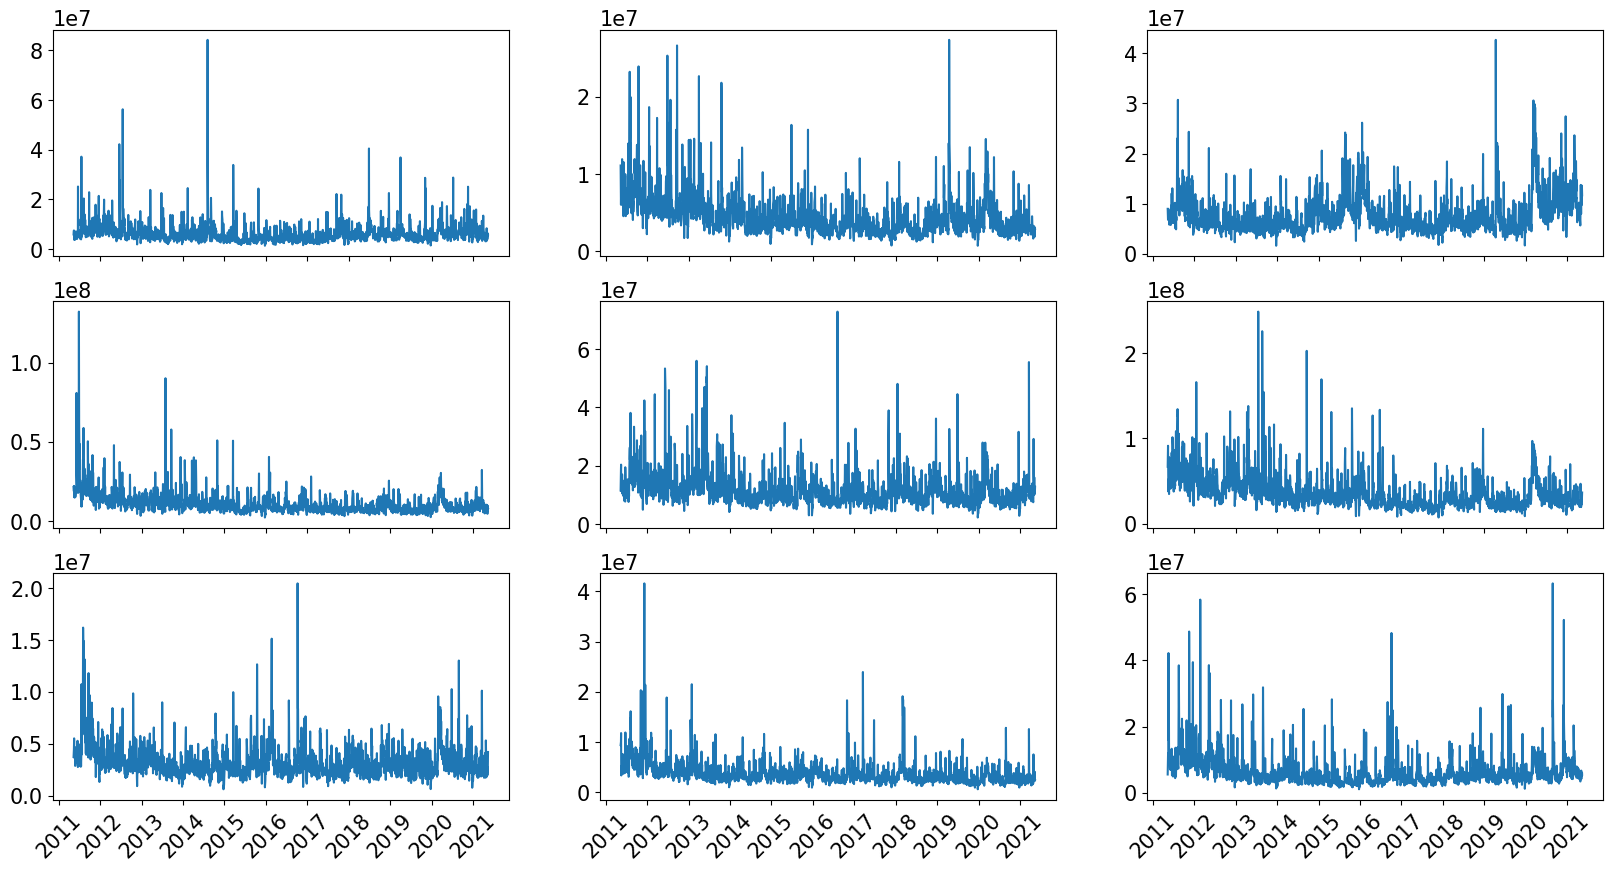

In [103]:
x = pd.to_datetime(_.index)
fig, ax = plt.subplots(3,3, figsize=(20,10), sharex=True)
for i in range(9):
  ax[i%3, i//3].plot(x, data[i])
  if i%3 > 1:
    ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
plt.show()


In [104]:
x.diff()

TimedeltaIndex([      NaT, '-1 days', '-1 days', '-3 days', '-1 days',
                '-1 days', '-1 days', '-1 days', '-3 days', '-1 days',
                ...
                '-1 days', '-1 days', '-1 days', '-1 days', '-3 days',
                '-1 days', '-1 days', '-1 days', '-1 days', '-3 days'],
               dtype='timedelta64[ns]', name='Date', length=2516, freq=None)

In [105]:
df = pd.DataFrame(data=data).T
df.index= pd.to_datetime(x, format="%m/%d/%y")
df_resampled = df.resample('2d').mean()#.fillna(df.mean())
df_resampled = df_resampled.interpolate(limit_direction='both')
df_resampled.index.diff().unique()

TimedeltaIndex([NaT, '2 days'], dtype='timedelta64[ns]', name='Date', freq=None)

In [106]:
df_resampled.shape

(1827, 29)

<ipython-input-107-a5651166551a>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
<ipython-input-107-a5651166551a>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
<ipython-input-107-a5651166551a>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)


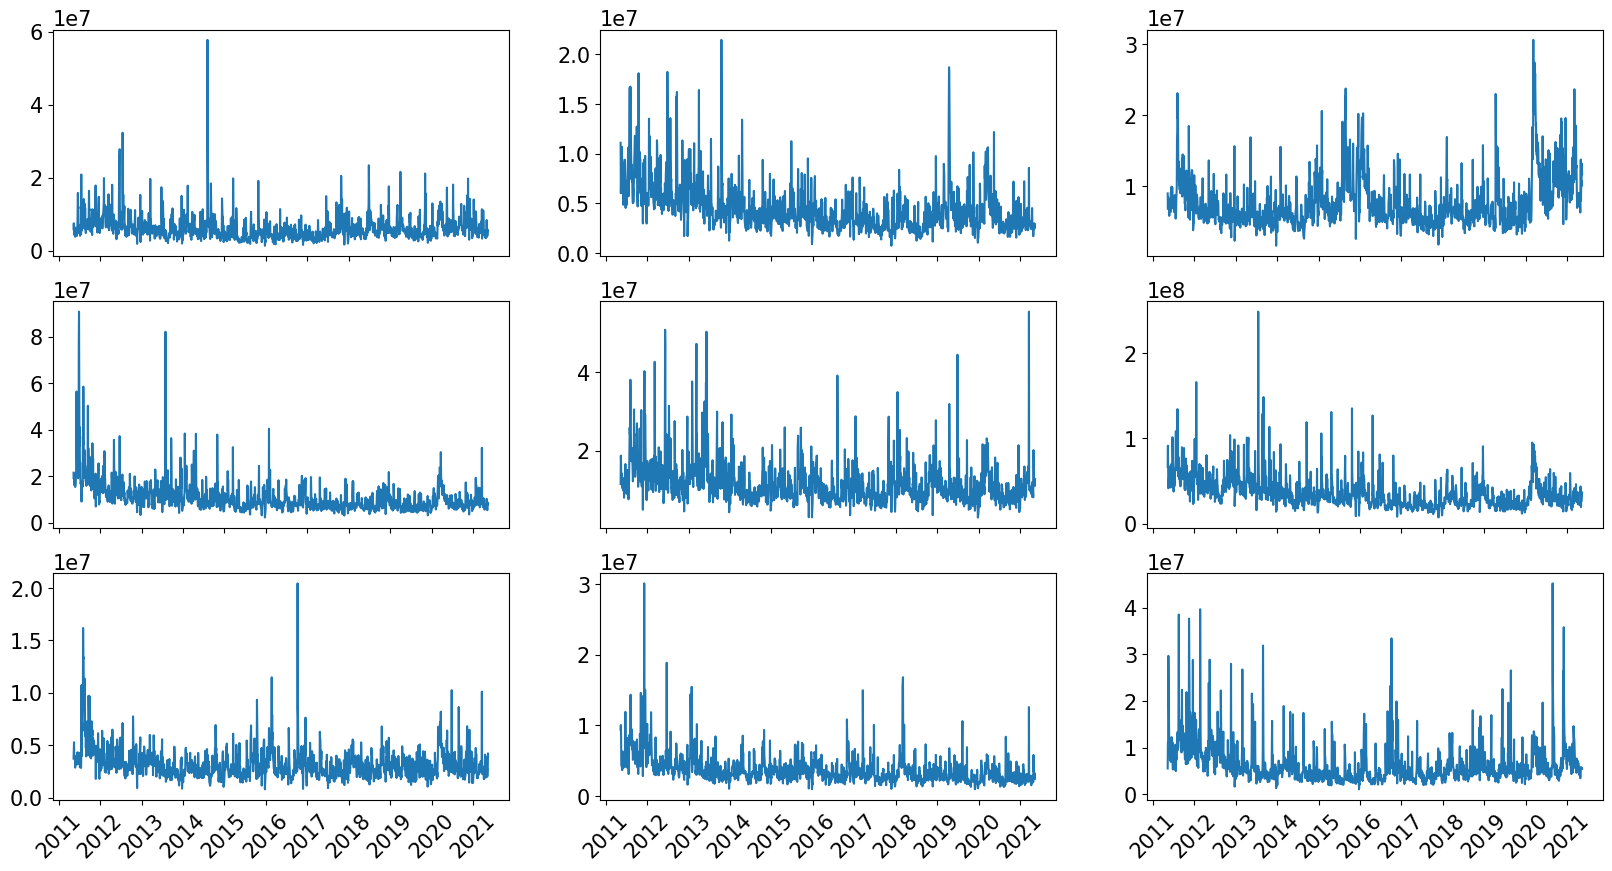

In [107]:
x = df_resampled.index
fig, ax = plt.subplots(3,3, figsize=(20,10), sharex=True)
for i in range(9):
  ax[i%3, i//3].plot(x, df_resampled.iloc[:,i])
  if i%3 > 1:
    ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
plt.show()


<ipython-input-115-93242b8a373c>:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
<ipython-input-115-93242b8a373c>:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
<ipython-input-115-93242b8a373c>:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)


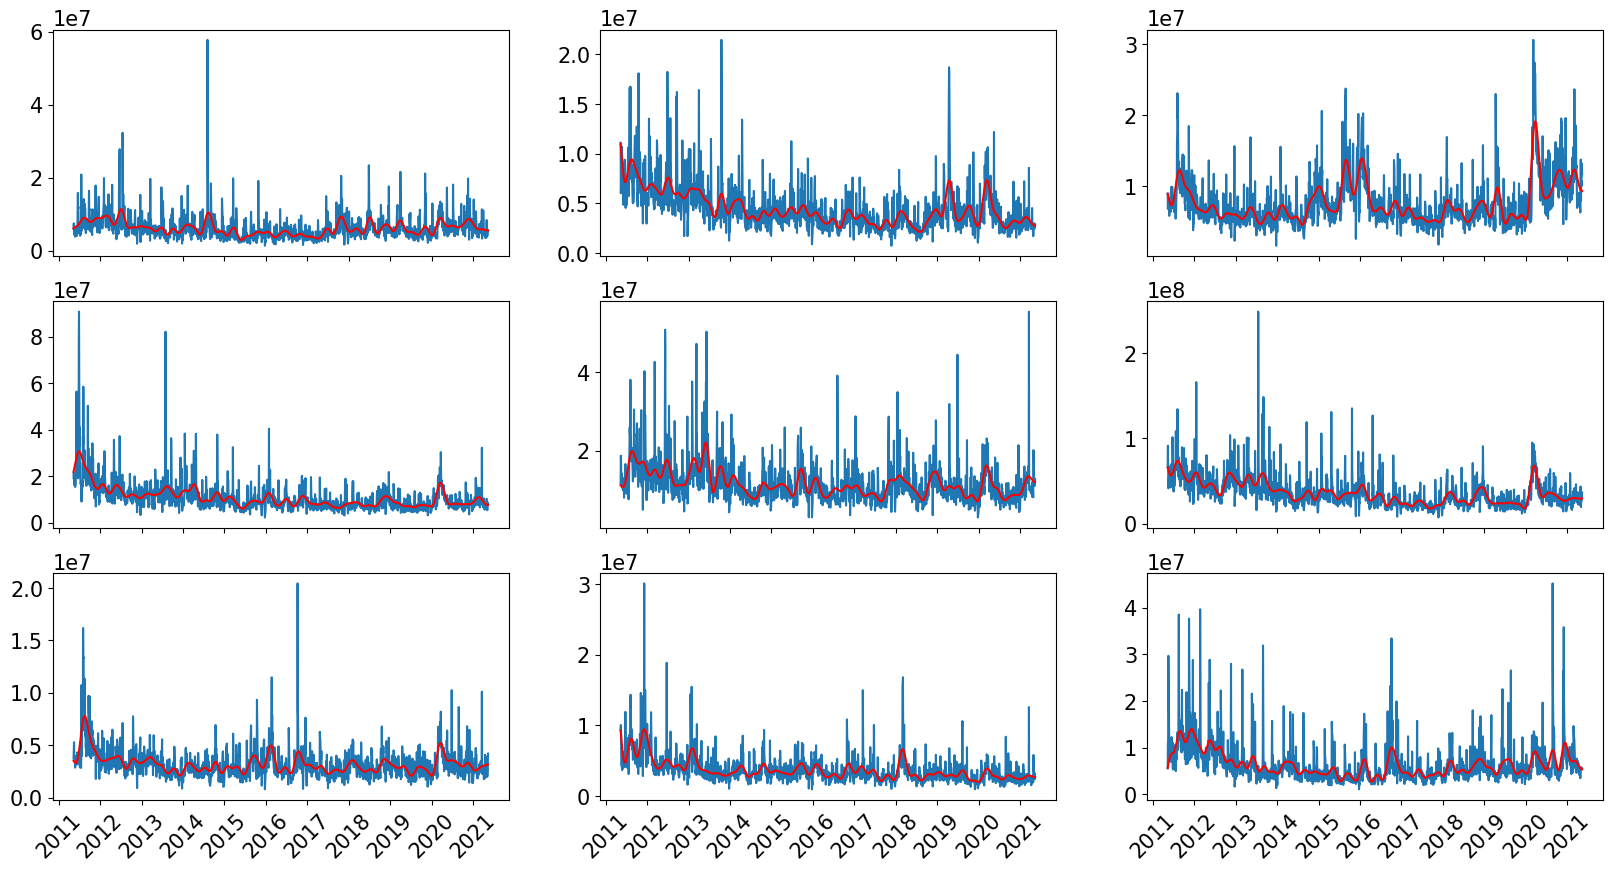

In [115]:
# prompt: lowpass filter the imput data
from scipy.signal import butter, lfilter, filtfilt


def butter_lowpass(cutoff, fs, order=5):
    """
    Design a digital Butterworth low-pass filter.

    The Butterworth filter is characterized by a maximally flat magnitude response
    in the passband and a monotonic roll-off in the stopband.  This function
    calculates the filter coefficients for a low-pass Butterworth filter.

    Args:
        cutoff (float): The cutoff frequency of the filter in Hz.  This is the
            frequency at which the filter's gain is reduced by 3 dB (half-power).
        fs (float): The sampling rate of the signal to be filtered, in Hz.
        order (int, optional): The order of the filter.  Higher order filters
            provide a steeper roll-off but also increase the filter's complexity
            and introduce more phase delay.  The default is 5.

    Returns:
        tuple: A tuple of two NumPy arrays, (b, a).
            - b (ndarray): The numerator coefficients of the filter's transfer function.
            - a (ndarray): The denominator coefficients of the filter's transfer function.

    The filter's transfer function is defined as:
    ∣H(jω)∣^2 = 1 / (1 + (ω/ωc)^(2n))

    Where:
    - ω is the angular frequency (2 * pi * frequency)
    - ωc is the cutoff angular frequency (2 * pi * cutoff)
    - n is the filter order
    """

    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """
    Apply a digital Butterworth low-pass filter to input data.

    This function designs and applies a Butterworth low-pass filter to the given
    input data using forward-backward filtering to minimize phase distortion.

    Args:
        data (ndarray): The input data to be filtered.  It should be a 1-D NumPy array.
        cutoff (float): The cutoff frequency of the filter in Hz.
            Frequencies above this will be attenuated.
        fs (float): The sampling rate of the input data, in Hz.
        order (int, optional): The order of the filter. Higher order filters
            provide a steeper roll-off but can increase complexity. The default is 5.

    Returns:
        ndarray: The filtered data, with the same shape as the input data.

    """
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

fs = 1/48  # Replace with your actual sampling frequency this is in hours

# Choose cutoff frequency (adjust based on desired filtering characteristics)
cutoff = 1/48/50

# Apply filter to each time series in 'data'
filtered_data = np.zeros_like(df_resampled.T.values)
for i in range(filtered_data.shape[0]):
    filtered_data[i, :] = butter_lowpass_filter(df_resampled.iloc[:,i], cutoff, fs, order=5)

# Now 'filtered_data' contains the low-pass filtered time series data
# You can proceed to plot or further analyze the filtered data

fig, ax = plt.subplots(3,3, figsize=(20,10), sharex=True)
for i in range(9):
  ax[i%3, i//3].plot(x, df_resampled.iloc[:,i])
  ax[i%3, i//3].plot(x, filtered_data[i], 'r')
  if i%3 > 1:
    ax[i%3, i//3].set_xticklabels(labels=ax[i%3, i//3].get_xticklabels(), rotation=45)
plt.show()


In [116]:
df_filtered = pd.DataFrame(data=filtered_data).T
df_filtered.index = x
df_filtered.index.diff().unique(),


(TimedeltaIndex([NaT, '2 days'], dtype='timedelta64[ns]', name='Date', freq=None),)

In [117]:
df_filtered

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Date,,,,,,,,,,,,,,,,,,,,,
2011-05-13,6.133773e+06,2.190934e+07,3.503001e+06,1.101535e+07,1.113300e+07,9.259940e+06,8.883431e+06,6.578553e+07,5.670782e+06,5.021691e+06,...,1.136637e+07,1.585729e+07,8.061302e+07,1.236746e+07,9.038670e+06,8.023799e+06,8.138247e+06,3.663073e+06,1.008836e+07,1.453246e+07
2011-05-15,6.201335e+06,2.234309e+07,3.471073e+06,1.072445e+07,1.106339e+07,8.873024e+06,8.753363e+06,6.477792e+07,5.986276e+06,4.984632e+06,...,1.123440e+07,1.568664e+07,7.970308e+07,1.206869e+07,9.236639e+06,8.112894e+06,7.979124e+06,3.681548e+06,1.025842e+07,1.427465e+07
2011-05-17,6.261419e+06,2.279489e+07,3.439817e+06,1.043194e+07,1.099613e+07,8.489529e+06,8.620782e+06,6.378855e+07,6.290164e+06,4.947945e+06,...,1.109976e+07,1.551712e+07,7.877636e+07,1.177508e+07,9.425170e+06,8.202416e+06,7.819701e+06,3.700479e+06,1.042962e+07,1.403093e+07
2011-05-19,6.314861e+06,2.326219e+07,3.410001e+06,1.014015e+07,1.093248e+07,8.112228e+06,8.487039e+06,6.282768e+07,6.580236e+06,4.912269e+06,...,1.096405e+07,1.535102e+07,7.783991e+07,1.148893e+07,9.604098e+06,8.292746e+06,7.661298e+06,3.720320e+06,1.060257e+07,1.380304e+07
2011-05-21,6.362550e+06,2.374216e+07,3.382437e+06,9.851391e+06,1.087376e+07,7.743868e+06,8.353550e+06,6.190545e+07,6.854517e+06,4.878262e+06,...,1.082899e+07,1.519071e+07,7.690102e+07,1.121252e+07,9.773409e+06,8.384374e+06,7.505259e+06,3.741555e+06,1.077798e+07,1.359253e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-04,5.564981e+06,7.656132e+06,3.145055e+06,2.794049e+06,1.208384e+07,2.668111e+06,9.393696e+06,2.966824e+07,5.456390e+06,5.474844e+06,...,7.441539e+06,1.487515e+07,2.014648e+07,8.493188e+06,8.157099e+06,8.001511e+06,2.906651e+06,1.477832e+07,1.612332e+07,7.302205e+06
2021-05-06,5.555218e+06,7.624426e+06,3.149870e+06,2.785486e+06,1.205517e+07,2.662055e+06,9.361254e+06,2.968591e+07,5.425610e+06,5.488886e+06,...,7.437000e+06,1.482804e+07,2.008585e+07,8.483915e+06,8.119264e+06,7.939605e+06,2.906758e+06,1.468681e+07,1.606729e+07,7.283732e+06
2021-05-08,5.546701e+06,7.597570e+06,3.154274e+06,2.778268e+06,1.203075e+07,2.656777e+06,9.334422e+06,2.970316e+07,5.399262e+06,5.501438e+06,...,7.433030e+06,1.478801e+07,2.003454e+07,8.476056e+06,8.087048e+06,7.887246e+06,2.907170e+06,1.460809e+07,1.601951e+07,7.267182e+06


In [118]:
#we are not going to use it but useful cause it may be inputts in gluonts: how do i make it a single column df?
df_filtered_long = df_filtered.reset_index()
df_filtered_long = df_filtered_long.melt(id_vars="Date")
df_filtered_long.set_index("Date", inplace=True)
df_filtered_long.index = pd.to_datetime(df_filtered_long.index)
df_filtered_long

,variable,value
Date,,
2011-05-13,0,6.133773e+06
2011-05-15,0,6.201335e+06
2011-05-17,0,6.261419e+06
2011-05-19,0,6.314861e+06
2011-05-21,0,6.362550e+06
...,...,...
2021-05-04,28,7.302205e+06
2021-05-06,28,7.283732e+06
2021-05-08,28,7.267182e+06


<ipython-input-119-de6af68ae52d>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);


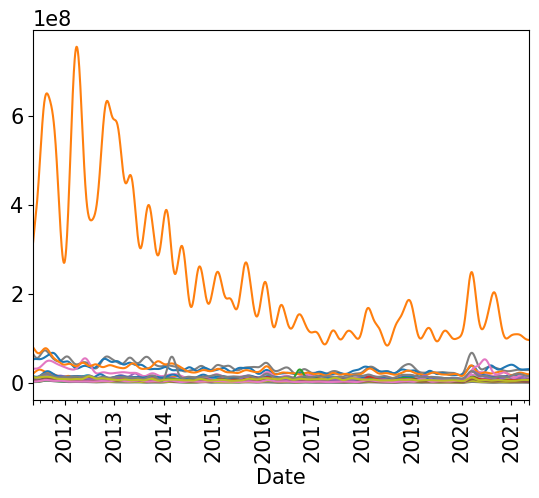

In [119]:
ax = df_filtered.plot(legend=False)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);


In [126]:
df_filtered.isna().sum().sum()

np.int64(0)

In [127]:
#import into gluonts
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

start_date = df_filtered.index[0]
train_data = []
test_data = []
for i in range(len(df_filtered.columns)):
    # Create synthetic time series with some dependencies
    target = df_filtered.iloc[:,i]

    train_target = target[:-prediction_length]
    test_target = target

    train_data.append({
        FieldName.TARGET: train_target,
        FieldName.START: start_date,
        FieldName.ITEM_ID: f"series_{i}"
    })
    test_data.append({
        FieldName.TARGET: test_target,
        FieldName.START: start_date,
        FieldName.ITEM_ID: f"series_{i}"
    })

# Convert to GluonTS ListDataset
train_dataset = ListDataset(train_data, freq="2d")
test_dataset = ListDataset(test_data, freq="2d")

## predict

In [128]:
list(train_dataset)[0]

{'target': array([6133772.5, 6201335.5, 6261419.5, ..., 5740239. , 5721674.5,
        5703033.5], dtype=float32),
 'start': Period('2011-05-13', '2D'),
 'item_id': 'series_0'}

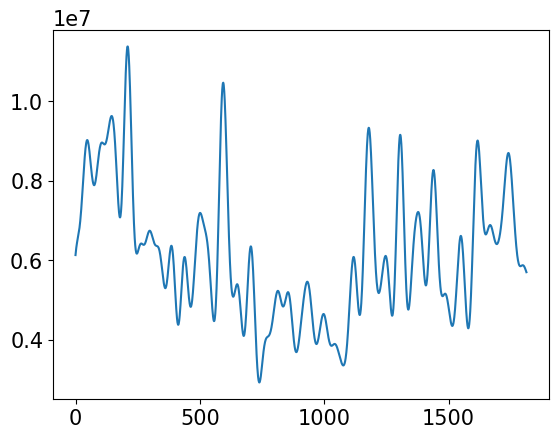

In [129]:
plt.plot(list(train_dataset)[0]["target"])


In [130]:
forecasts, tss = get_lag_llama_predictions(
    test_dataset,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/29 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/29 [00:00<?, ?it/s]

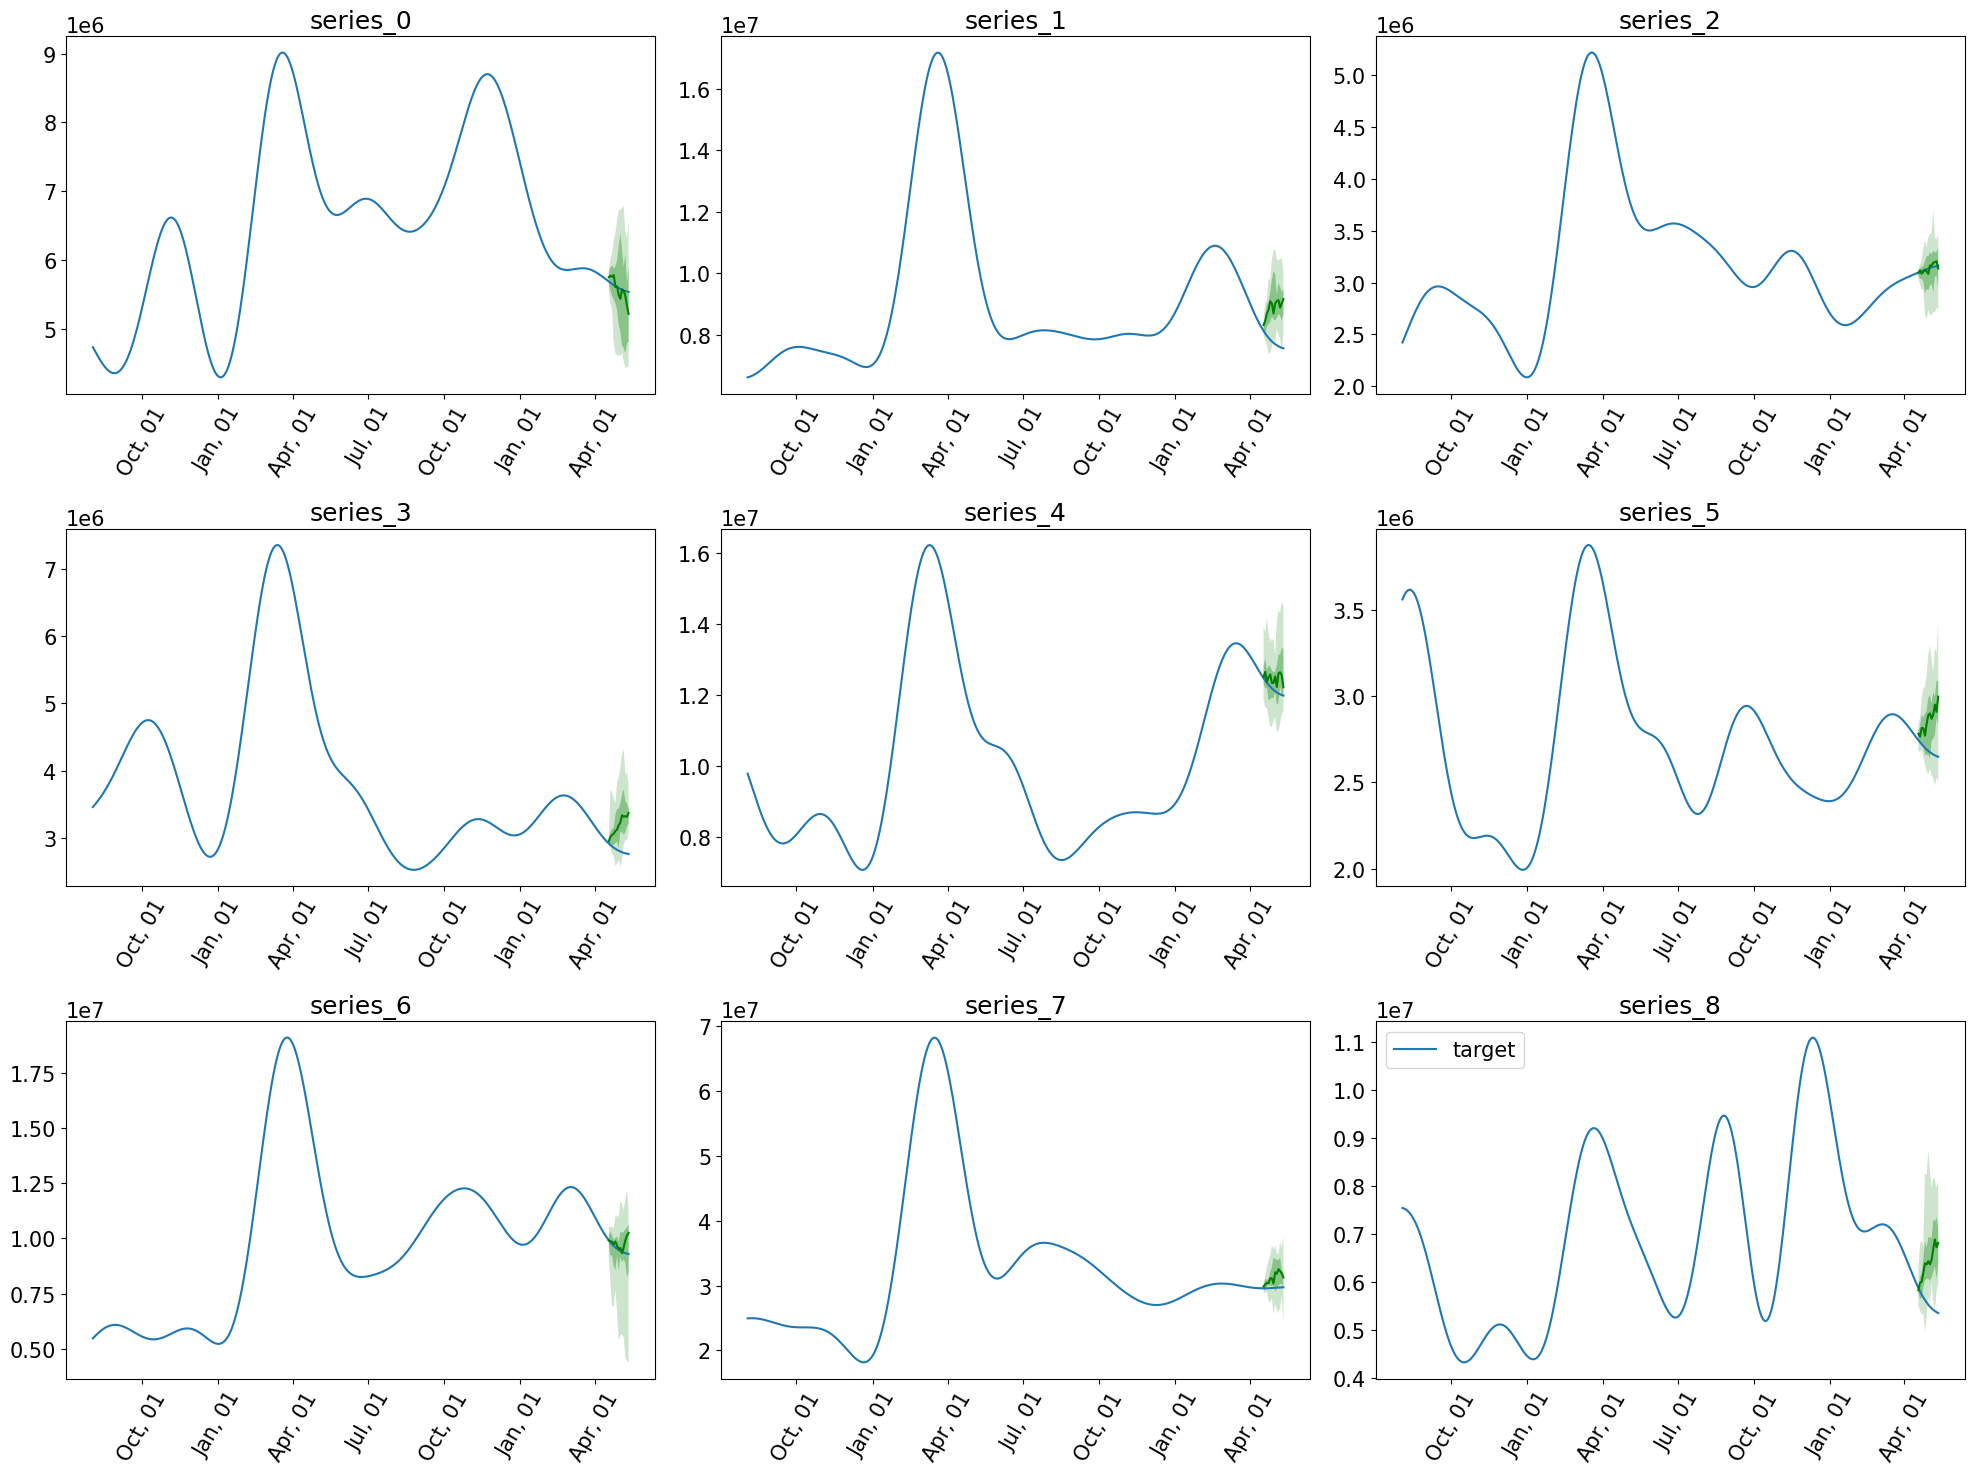

In [131]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-25 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [142]:
ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,
        #lr=5e-6,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [143]:
predictor = estimator.train(train_dataset,
    cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Tra

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 13.98596 (best 13.98596), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 13.98596 (best 13.98596), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 12.97846 (best 12.97846), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 12.97846 (best 12.97846), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 12.57045 (best 12.57045), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:

In [144]:
forecast_it, ts_it = make_evaluation_predictions(
        test_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

In [145]:
forecasts = list(tqdm(forecast_it, total=len(test_dataset), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/29 [00:00<?, ?it/s]

In [146]:
tss = list(tqdm(ts_it, total=len(test_dataset), desc="Ground truth"))

Ground truth:   0%|          | 0/29 [00:00<?, ?it/s]

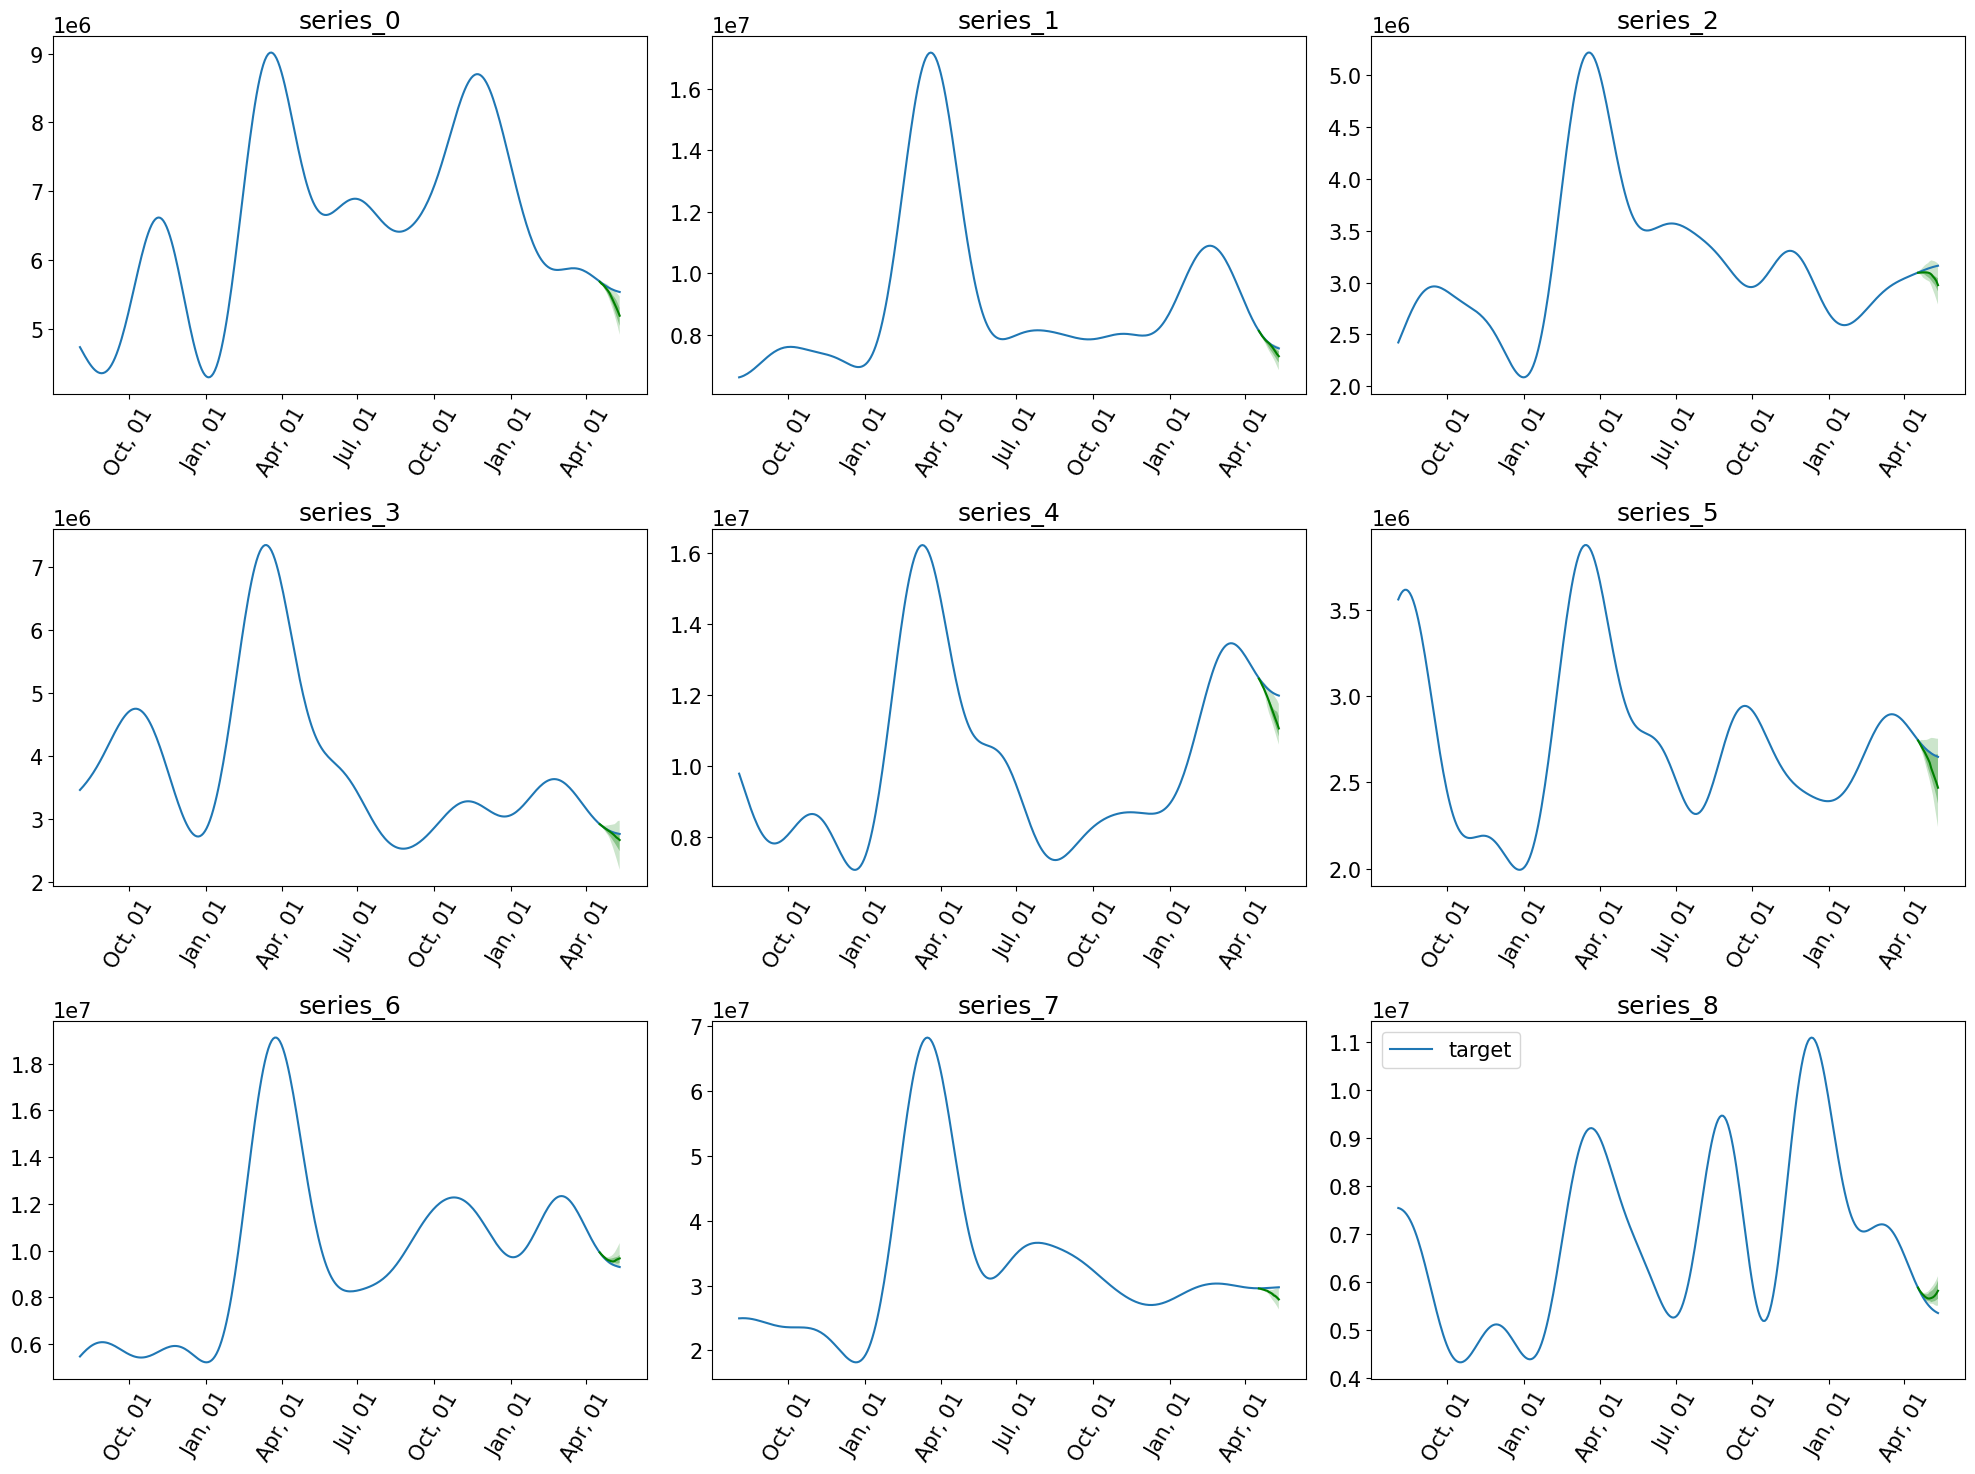

In [147]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-25 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [138]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 29it [00:00, 940.57it/s]


In [139]:
agg_metrics

{'MSE': np.float64(51345940212206.34),
 'abs_error': np.float64(1520805515.5),
 'abs_target_sum': np.float64(4625062618.0),
 'abs_target_mean': np.float64(12268070.604774537),
 'seasonal_error': np.float64(181544.99435114214),
 'MASE': np.float64(28.549784260026147),
 'MAPE': np.float64(0.28350776576236963),
 'sMAPE': np.float64(0.3895109762247425),
 'MSIS': np.float64(288.3819868749274),
 'num_masked_target_values': np.float64(0.0),
 'QuantileLoss[0.1]': np.float64(475148498.825),
 'Coverage[0.1]': np.float64(0.005305039787798409),
 'QuantileLoss[0.2]': np.float64(862867978.1500001),
 'Coverage[0.2]': np.float64(0.005305039787798409),
 'QuantileLoss[0.3]': np.float64(1167422994.5375),
 'Coverage[0.3]': np.float64(0.007957559681697613),
 'QuantileLoss[0.4]': np.float64(1344998540.9),
 'Coverage[0.4]': np.float64(0.010610079575596818),
 'QuantileLoss[0.5]': np.float64(1520805514.875),
 'Coverage[0.5]': np.float64(0.0636604774535809),
 'QuantileLoss[0.6]': np.float64(1701669615.3999999),